#  Regressão Linear com Spark usando PySpark

A **regressão linear** é um algoritmo de **aprendizado de máquina supervisionado** que utiliza dados históricos para estimar o valor de algo, permitindo a previsão de eventos futuros. Existem dois tipos principais de regressão linear: simples e múltipla. A **regressão linear simples** é usada quando há apenas uma variável independente (X) para prever um resultado, enquanto a **regressão linear múltipla** é utilizada quando várias variáveis independentes (X) são necessárias para fazer a previsão.

![image.png](rl.png)


## Inicializando o PySpark

In [225]:
import findspark
import pyspark
from pyspark.sql import SparkSession

# Faz a Interafce entre o Spark e o Jupyter Notebook
findspark.init()

# Inicializando uma Sessão no Spark
spark = SparkSession.builder.appName("regresaolinear").getOrCreate()

### Hiper Parâmetros

> + **loss**: função de perda. squaredError, huber. (padrão: squaredError)
> + **maxIter**: número máximo de interações. (padrão 100)
> + **standardization**: define se os dados devem ser padronizados antes de criar o modelo. (padrão true)


---

## Aplicando Regressão Linear Multipla no DataSet Carros



### Carregando o Cunjunto de Dados Carros

In [226]:
carros_data = spark.read.csv("../Material_do_Curso/Carros.csv",
                             header=True, inferSchema=True, sep=";")
print(f"Quantidade de Registros do Dataset: {carros_data.count()}")
carros_data.show(5, truncate=True)

Quantidade de Registros do Dataset: 32
+-------+---------+-----------+---------------+----+-----+---------+-----------+-------+-----------+---+
|Consumo|Cilindros|Cilindradas|RelEixoTraseiro|Peso|Tempo|TipoMotor|Transmissao|Marchas|Carburadors| HP|
+-------+---------+-----------+---------------+----+-----+---------+-----------+-------+-----------+---+
|     21|        6|        160|             39| 262| 1646|        0|          1|      4|          4|110|
|     21|        6|        160|             39|2875| 1702|        0|          1|      4|          4|110|
|    228|        4|        108|            385| 232| 1861|        1|          1|      4|          1| 93|
|    214|        6|        258|            308|3215| 1944|        1|          0|      3|          1|110|
|    187|        8|        360|            315| 344| 1702|        0|          0|      3|          2|175|
+-------+---------+-----------+---------------+----+-----+---------+-----------+-------+-----------+---+
only showing top

### Escolha das Variáveis Independentes e Dependente para treinamento do Modelo

Para esse exemplo, as variáveis dependentes serão os atritutos  **Consumo | Cilindros | Cilindradas |** e a variável Dependente será o Atributo **| HP |**

ou seja, vamos usar as variáveis independentes para prever a dependente, para isso, vamos treinar o modelo com os dados do dataset.

### Importação do Módulo do PySpark Para o Pré-Processamento dos Dados

In [227]:
from pyspark.ml.feature import RFormula

In [228]:
# Colocando os dados no Formato de dataframe do Spark usando o RFormula
rformula = RFormula(formula="HP ~ Consumo + Cilindros + Cilindradas",
                    featuresCol="independentes", labelCol="dependente")
carros_rf = rformula.fit(carros_data).transform(carros_data)
carros_rf.select("independentes", "dependente").show(5, truncate=False)

+-----------------+----------+
|independentes    |dependente|
+-----------------+----------+
|[21.0,6.0,160.0] |110.0     |
|[21.0,6.0,160.0] |110.0     |
|[228.0,4.0,108.0]|93.0      |
|[214.0,6.0,258.0]|110.0     |
|[187.0,8.0,360.0]|175.0     |
+-----------------+----------+
only showing top 5 rows



### Separando os Dados entre conjunto de Treino e Teste

O Conjunto de dados serão separados entre treino e teste, sendo que **80%** será para treinar o modelo e **20%** para testar o modelo.

In [229]:
carros_train, carros_test = carros_rf.randomSplit([0.8, 0.2])
print(f"Quantidade de Dados de Treino: {carros_train.count()}")
print(f"Quantidade de Dados de Teste: {carros_test.count()}")

Quantidade de Dados de Treino: 26
Quantidade de Dados de Teste: 6


---

### Importação do Módulo do PySpark Para Criação do Modelo de Regressão Linear 

In [230]:
from pyspark.ml.regression import LinearRegression

#### Instanciando Objeto e criando o Modelo

In [231]:
# Instanciando o objeto LinearRegression
obj_rl = LinearRegression(featuresCol="independentes",
                          labelCol="dependente",
                          maxIter=1000, loss="squaredError",
                          standardization=True)

# Criando o Modelo
model_rl = obj_rl.fit(carros_train)

23/03/03 18:00:42 WARN Instrumentation: [e0eba5cc] regParam is zero, which might cause numerical instability and overfitting.


#### Realizando Presição com o Modelo Criado

In [232]:
previsao_test = model_rl.transform(carros_test)
previsao_test.select("dependente", "prediction").show(5)

+----------+------------------+
|dependente|        prediction|
+----------+------------------+
|     335.0|191.95873556163994|
|     205.0| 192.3449203559623|
|     245.0|193.13143666387072|
|     180.0|185.43711542603546|
|      93.0| 82.02138533880868|
+----------+------------------+
only showing top 5 rows



### Avaliando o Modelo

In [233]:
from pyspark.ml.evaluation import RegressionEvaluator

In [234]:
avaliar = RegressionEvaluator(predictionCol="prediction",
                              labelCol="dependente",
                              metricName="rmse")
rmse = avaliar.evaluate(previsao)
print(f"rmse: {rmse}")

rmse: 48.90825381921658


O **desvio quadrático médio** ou **erro quadrático médio** é uma medida frequentemente usada das diferenças entre os valores previstos por um modelo ou estimador e os valores observados. dessa forma, quanto menor for esse valor melhor o modelo.

Para o modelo avaliado nesse exemplo, podemos observar que esse valor é relativamente grande, isso ocorre por conta do tamanho do conjunto de dados que é pequeno.

---

## Visualização Gráfica dos Dados (Reais vs Previsão) do Conjunto de Treino

In [235]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ggplot")

In [236]:
previsao_train = model_rl.transform(carros_train)
previsao_train.select("dependente",
                      "prediction",
                      "Cilindradas").show(5)

+----------+------------------+-----------+
|dependente|        prediction|Cilindradas|
+----------+------------------+-----------+
|     110.0|136.06328291055203|        160|
|     110.0|136.06328291055203|        160|
|      91.0| 76.24733856113257|       1203|
|     215.0|192.38454678699574|        460|
|     245.0|193.05762032607473|        350|
+----------+------------------+-----------+
only showing top 5 rows



### Convertendo os Dados Para Array NumPy

In [237]:
previsao_train_numpy = previsao_train.select("dependente",
                                             "prediction",
                                             "Cilindradas")
previsao_train_numpy.show(5)
previsao_train_numpy = previsao_train_numpy.toPandas().to_numpy()

previsao_train_numpy.shape

+----------+------------------+-----------+
|dependente|        prediction|Cilindradas|
+----------+------------------+-----------+
|     110.0|136.06328291055203|        160|
|     110.0|136.06328291055203|        160|
|      91.0| 76.24733856113257|       1203|
|     215.0|192.38454678699574|        460|
|     245.0|193.05762032607473|        350|
+----------+------------------+-----------+
only showing top 5 rows



(26, 3)

### Plotagem dos Gráficos para Compar os Valores Reais com os Estimados pelo Modelo

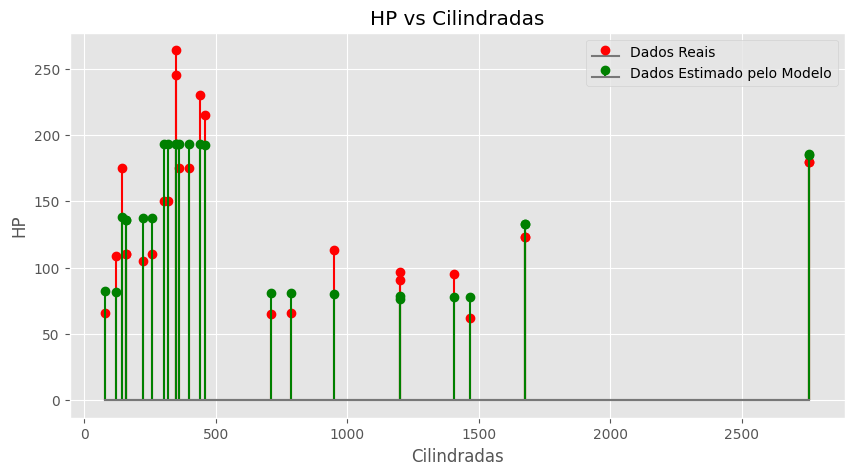

In [238]:
fig1, ax1 = plt.subplots(figsize=(10, 5))
ax1.stem(previsao_train_numpy[:, 2], previsao_train_numpy[:, 0],
         "r", markerfmt="ro", label="Dados Reais")
ax1.stem(previsao_train_numpy[:, 2], previsao_train_numpy[:, 1],
         "g", markerfmt="go", label="Dados Estimado pelo Modelo")
plt.title("HP vs Cilindradas")
ax1.set_xlabel("Cilindradas")
ax1.set_ylabel("HP")
ax1.legend()
plt.show()

---

## Visualização Gráfica dos Dados (Reais vs Previsão) do Conjunto de Testes

### Convertendo os Dados Para Array NumPy

In [239]:
previsao_test_numpy = previsao_test.select("dependente",
                                           "prediction",
                                           "Cilindradas")
previsao_test_numpy.show(5)
previsao_test_numpy = previsao_test_numpy.toPandas().to_numpy()

previsao_test_numpy.shape

+----------+------------------+-----------+
|dependente|        prediction|Cilindradas|
+----------+------------------+-----------+
|     335.0|191.95873556163994|        301|
|     205.0| 192.3449203559623|        472|
|     245.0|193.13143666387072|        360|
|     180.0|185.43711542603546|       2758|
|      93.0| 82.02138533880868|        108|
+----------+------------------+-----------+
only showing top 5 rows



(6, 3)

### Plotagem dos Gráficos para Compar os Valores Reais com os Estimados pelo Modelo

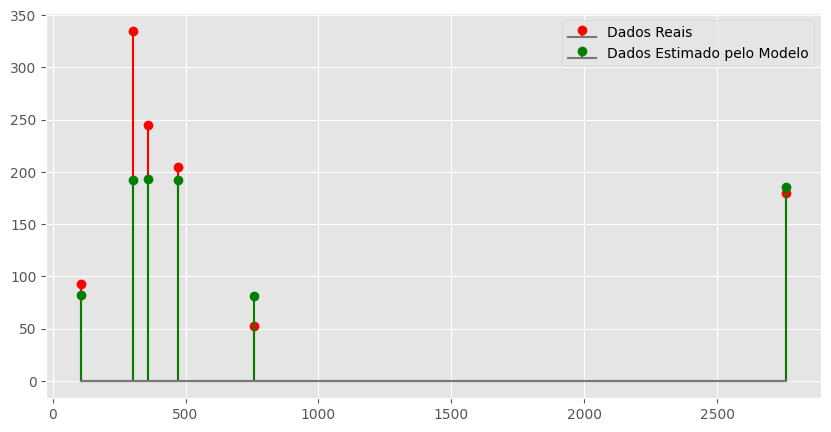

In [240]:
fig2, ax2 = plt.subplots(figsize=(10, 5))
ax2.stem(previsao_test_numpy[:, 2], previsao_test_numpy[:, 0],
         "r", markerfmt="ro", label="Dados Reais")
ax2.stem(previsao_test_numpy[:, 2], previsao_test_numpy[:, 1],
         "g", markerfmt="go", label="Dados Estimado pelo Modelo")
ax2.legend()
plt.show()